In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from common.utils import load_variable, vote_by_user


# Enth

## Loading raw dataset

In [2]:
# File obtained from Cohort-comfort paper processing TODO add reference
df_enth_features_raw = pd.read_csv("data/enth/ENTH_tabular_merged.csv")

print(f'Raw features:\n{df_enth_features_raw.columns.values}')
print(f'Dimensions: {df_enth_features_raw.shape}')
print('\nFeatures:')
print(df_enth_features_raw['air_vel'].unique())
print(df_enth_features_raw['building_name'].unique())
print(df_enth_features_raw['clothing'].unique())
print(df_enth_features_raw['met'].unique())
print(df_enth_features_raw['met'].value_counts())
print(df_enth_features_raw['comfort'].unique())
print(df_enth_features_raw['thermal'].unique())
print('\nMissing rows:')
print(df_enth_features_raw.isna().sum())
df_enth_features_raw.head(5)


Raw features:
['time' 'space_id' 'building_name' 'air_vel' 'body_presence' 'change'
 'clothing' 'comfort' 'heartrate' 'indoor/outdoor' 'met' 'response_speed'
 'resting_heartrate' 'thermal' 'nb_temp' 'indoor_floor' 'indoor_latitude'
 'indoor_longitude' 'skin_temp' 'co2_indoor' 'voc_indoor' 'pm25_indoor'
 'noise_indoor' '0.3um_count_outdoor' '0.5um_count_outdoor'
 '1.0um_count_outdoor' '10.0um_count_outdoor' '2.5um_count_outdoor'
 '5.0um_count_outdoor' 'humidity_outdoor' 'pm1.0_outdoor' 'pm10.0_outdoor'
 'pm2.5_outdoor' 'pressure_outdoor' 'temp_outdoor' 'user_id' 'temp_zone'
 'humidity_zone']
Dimensions: (1403, 38)

Features:
[10. 11. nan]
['SDE4' 'SDE2' nan 'SDE1']
[10.  9. 11. nan  8.]
[ 9. 10.  8. 11. nan]
9.0     1191
10.0     204
8.0        5
11.0       2
Name: met, dtype: int64
[10.  9. nan]
[11. 10. nan  9.]

Missing rows:
time                       0
space_id                   0
building_name            169
air_vel                    1
body_presence              0
change         

,time,space_id,building_name,air_vel,body_presence,change,clothing,comfort,heartrate,indoor/outdoor,...,5.0um_count_outdoor,humidity_outdoor,pm1.0_outdoor,pm10.0_outdoor,pm2.5_outdoor,pressure_outdoor,temp_outdoor,user_id,temp_zone,humidity_zone
0,2021-03-17 15:30:00+08:00,2,SDE4,10.0,True,10.0,10.0,10.0,87.0,11.0,...,0.56,NaN,8.67,12.83,12.21,NaN,NaN,enth15,NaN,NaN
1,2021-03-17 15:33:00+08:00,2,SDE4,10.0,True,10.0,10.0,10.0,67.0,11.0,...,0.56,NaN,8.67,12.83,12.21,NaN,NaN,enth15,NaN,NaN
2,2021-03-17 15:53:00+08:00,2,SDE4,10.0,True,10.0,10.0,9.0,87.0,9.0,...,1.58,NaN,5.31,9.04,7.71,NaN,NaN,enth15,NaN,NaN
3,2021-03-17 16:08:00+08:00,210,SDE2,11.0,True,10.0,10.0,10.0,70.0,11.0,...,0.21,58.0,6.41,9.59,9.09,1003.94,28.89,enth15,NaN,NaN
4,2021-03-17 16:23:00+08:00,210,SDE2,11.0,True,10.0,10.0,10.0,66.0,11.0,...,0.42,NaN,8.47,13.34,13.06,NaN,NaN,enth15,24.919891,NaN


## Preprocessing

In [3]:
df_enth_features_indoor = df_enth_features_raw.copy() 

# only indoor steady-state data
df_enth_features_indoor = df_enth_features_indoor[df_enth_features_indoor["change"] == 10]
df_enth_features_indoor = df_enth_features_indoor[df_enth_features_indoor["met"] != 11]
df_enth_features_indoor = df_enth_features_indoor[df_enth_features_indoor["building_name"].notna()]
# remove rows where clothing is 'very light' since it is not an option for commercial buildings
df_enth_features_indoor = df_enth_features_indoor[df_enth_features_indoor["clothing"] != 8]

print(f'\nOnly indoor votes: {df_enth_features_indoor.shape}')



Only indoor votes: (981, 38)


Filtered features:
 ['clothing' 'met' 'resting_heartrate' 'thermal_cozie' 'nb_temp' 'user_id'
 't-ubi']

Missing rows:
clothing               0
met                    0
resting_heartrate      0
thermal_cozie          0
nb_temp               21
user_id                0
t-ubi                337
dtype: int64

Dropping NaNs rows
clothing             0
met                  0
resting_heartrate    0
thermal_cozie        0
nb_temp              0
user_id              0
t-ubi                0
dtype: int64
New dimensions: (631, 7)
New features: ['clothing' 'met' 'resting_heartrate' 'thermal_cozie' 'nb_temp' 'user_id'
 't-ubi']
Min responses/participant: 1
Max responses/participant: 89


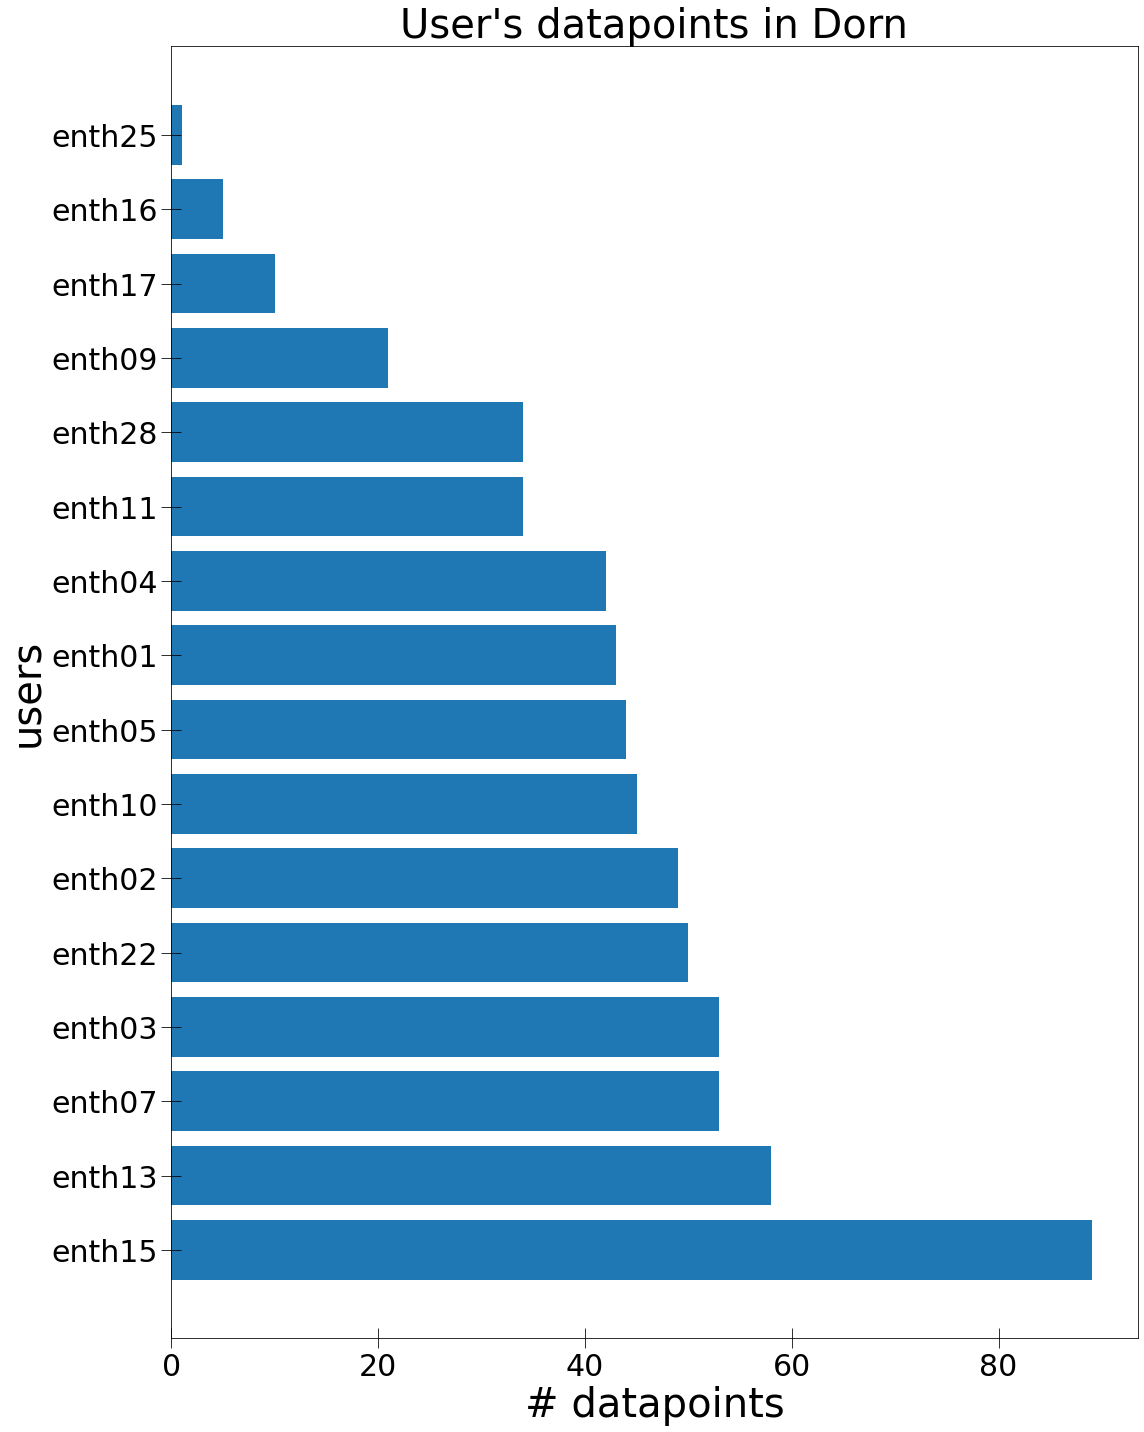

In [4]:
 # ['air-vel' 'clothing' 'heartRate' 'met' 'thermal_cozie' 'user_id' 't-nb'
 # 't-ubi' 'rh-ubi']
drop_columns = [
    'time',
    'space_id',
    'building_name',
    'air_vel',
    'body_presence',
    'change',
    'heartrate',
    'indoor/outdoor',
    # 'clothing',
    'comfort',
    'response_speed', 
#     'met', # needed for PMV
    # 'resting_heartrate',
    # 'nb_temp', # near body air temperature ibutton
    'indoor_floor',
    'indoor_latitude',
    'indoor_longitude',
    'skin_temp',
    'co2_indoor',
    'voc_indoor',
    'pm25_indoor',
    'noise_indoor',
    '0.3um_count_outdoor',
    '0.5um_count_outdoor',
    '1.0um_count_outdoor',
    '10.0um_count_outdoor',
    '2.5um_count_outdoor',
    '5.0um_count_outdoor',
    'humidity_outdoor',
    'pm1.0_outdoor',
    'pm10.0_outdoor',
    'pm2.5_outdoor',
    'pressure_outdoor',
    'temp_outdoor',
    # 'user_id',
    # 'temp_zone', # temperature indoor
    'humidity_zone' # humidity indoor
]

# drop unused features, rename columns, and remap labels
df_enth_features_filtered = df_enth_features_indoor.drop(drop_columns, axis=1)
df_enth_features_filtered = df_enth_features_filtered.rename(columns={
    'thermal':'thermal_cozie', 
    'userid':'user_id',
    'temp_zone':'t-ubi'})

print(f'Filtered features:\n {df_enth_features_filtered.columns.values}')

# drop NaN rows regarding physiological and environmental features
print('\nMissing rows:')
print(df_enth_features_filtered.isna().sum())
print('\nDropping NaNs rows')
non_nans_cols = ['nb_temp',
                 't-ubi']
for col in non_nans_cols:
    df_enth_features_filtered = df_enth_features_filtered[df_enth_features_filtered[col].notna()]
print(df_enth_features_filtered.isna().sum())

print(f'New dimensions: {df_enth_features_filtered.shape}')
print(f'New features: {df_enth_features_filtered.columns.values}')

user_data_dist = df_enth_features_filtered['user_id'].value_counts()

print(f'Min responses/participant: {min(user_data_dist)}')
print(f'Max responses/participant: {max(user_data_dist)}')

figure, ax = plt.subplots(1, 1, figsize=(16, 20))
ax.barh(user_data_dist.index, user_data_dist, align='center')

ax.tick_params(length=20, direction="inout", labelsize=30)
ax.set_ylabel('users', size=40)
ax.set_xlabel('# datapoints', size=40)
plt.xticks(rotation=0)
ax.set_title('User\'s datapoints in Dorn', size=40)
plt.tight_layout()
plt.show()

figure.savefig(f"img/enth_datadist_filtered.png")


## Equal datapoints for all users

In [5]:
# get min num_samples of datapoints for users
num_samples = 20
df_enth_env_same_size = pd.DataFrame()

for user in df_enth_features_filtered['user_id'].unique():
    df_user = df_enth_features_filtered[df_enth_features_filtered['user_id'] == user]
    if df_user.shape[0] >= num_samples:
        df_enth_env_same_size = df_enth_env_same_size.append(df_user)
    
df_enth_env_same_size = df_enth_env_same_size.drop("met", axis=1)
df_enth_env_same_size.to_csv('data/enth/ENTH_env_20.csv', index=False)

print(f'Dimensions with equal size datapoints: {df_enth_env_same_size.shape}')
print(f'Per user:\n{df_enth_env_same_size["user_id"].value_counts()}')
print(f'Final features to be use\n: {df_enth_env_same_size.columns.values}')


Dimensions with equal size datapoints: (615, 6)
Per user:
enth15    89
enth13    58
enth07    53
enth03    53
enth22    50
enth02    49
enth10    45
enth05    44
enth01    43
enth04    42
enth11    34
enth28    34
enth09    21
Name: user_id, dtype: int64
Final features to be use
: ['clothing' 'resting_heartrate' 'thermal_cozie' 'nb_temp' 'user_id'
 't-ubi']


# Occupant Tolerance

/Users/maqr/Documents/project-data/admin__abm-demo/comfortlearn/common/utils.py:320: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_total = _df.sum(axis=1)


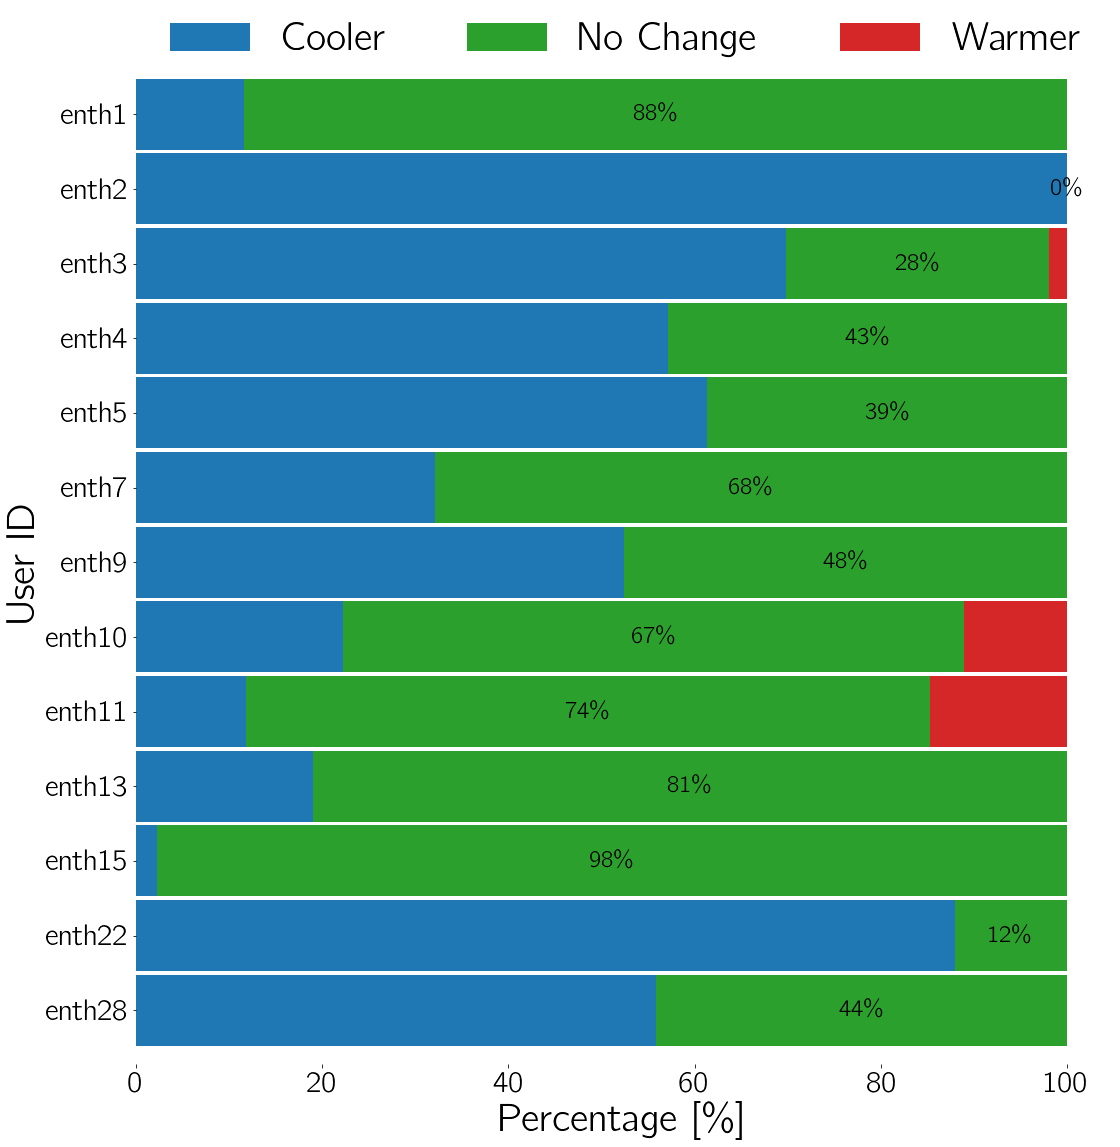

   user_id  tolerance
0   enth01  88.372093
1   enth02   0.000000
2   enth03  28.301887
3   enth04  42.857143
4   enth05  38.636364
5   enth07  67.924528
6   enth09  47.619048
7   enth10  66.666667
8   enth11  73.529412
9   enth13  81.034483
10  enth15  97.752809
11  enth22  12.000000
12  enth28  44.117647


/var/folders/4x/wjc3mgwn25g5tqcnz7hyv_440000gn/T/ipykernel_37260/3466139575.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_total = _df.sum(axis=1)


In [6]:
df = pd.read_csv('data/enth/ENTH_env_20.csv')
vote_by_user(df, dataset="enth", show_percentages=True)

_df = (df.groupby(["user_id", "thermal_cozie"])["thermal_cozie"]
        .count()
        .unstack("thermal_cozie")
)
_df.reset_index(inplace=True)

df_total = _df.sum(axis=1)
df_rel = _df[_df.columns[1:]].div(df_total, 0) * 100
df_rel["user_id"] = _df["user_id"]

df_tolerance = pd.DataFrame()
df_tolerance["user_id"] = df_rel["user_id"]
df_tolerance["tolerance"] = df_rel.iloc[:,1]
df_tolerance["tolerance"] = df_tolerance["tolerance"].fillna(0)

df_tolerance.to_csv("data/enth/ENTH_tol_20.csv")
print(df_tolerance)
